# 02. Neural Network Classification with PyTorch

Classigication is a problem of identifying to which of a set of categories a new observation belongs, on the basis of a training set of data containing observations whose category membership is known. In this notebook, we will use a neural network to classify the images of the Fashion MNIST dataset.

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, 
                    noise=0.05)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples: {X[:5]}")
print(f"First 5 labels: {y[:5]}")

First 5 samples: [[ 0.41564962  0.85693657]
 [-0.03713013 -0.9777017 ]
 [ 0.62983992 -0.43136056]
 [-0.26887331  0.78074302]
 [ 0.97349899  0.18218382]]
First 5 labels: [0 0 1 1 0]


In [5]:
# Make DataFrame of circle data

import pandas as pd

circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})

circles.head()  

,X0,X1,label
0,0.415650,0.856937,0
1,-0.037130,-0.977702,0
2,0.629840,-0.431361,1
3,-0.268873,0.780743,1
4,0.973499,0.182184,0


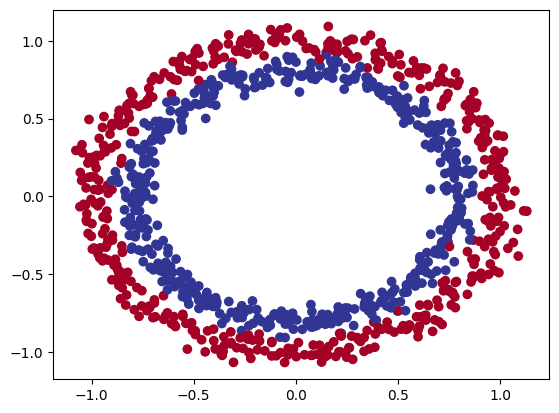

In [6]:
# Visualize the data
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], 
            X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu) # scatter plot of first two features, colored by the target

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.41564962,  0.85693657],
       [-0.03713013, -0.9777017 ],
       [ 0.62983992, -0.43136056],
       ...,
       [ 0.95022828,  0.02827823],
       [ 0.44529906, -0.70465546],
       [-0.8226471 , -0.48924555]])

In [9]:
# View the first example of features and labels

X_sample = X[0]
y_sample = y[0]

print(f"X sample: {X_sample} and y sample: {y_sample}")
print(f"X sample shape: {X_sample.shape} and y sample shape: {y_sample.shape}")

X sample: [0.41564962 0.85693657] and y sample: 0
X sample shape: (2,) and y sample shape: ()


### 1.2 Turn data into tensors and create train and test sets

In [10]:
import torch
torch.__version__

'2.4.0+cu121'

In [11]:
# Turn data into tensors

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [12]:
X[:5], y[:5]

(tensor([[ 0.4156,  0.8569],
         [-0.0371, -0.9777],
         [ 0.6298, -0.4314],
         [-0.2689,  0.7807],
         [ 0.9735,  0.1822]]),
 tensor([0., 0., 1., 1., 0.]))

In [13]:
# Split data into training and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonistic code so our code will run on an accelerator (like a GPU) if it's available and if not, it'll fall back to using a CPU.
2. Create a model using the PyTorch `nn.Module` class.
3. Define a loss function and optimizer 
4. Create a training loop to learn the patterns in the data (the weights in the model) by adjusting the weights based on the output of the model compared to the true labels.
5. Evaluate the model on the test set to see how well it's learned.

In [15]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we have our data ready, let’s build a neural network to learn the patterns in the data.

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`).
2. Create 2 `nn.Linear` layers (input layer and output layer).
3. Define a `forward` method which returns the output layer after applying the activation function.
4. Instatiate an instance of our model class and send it to the `device`.

In [16]:
# 1. COnstruct a model that subclasses the nn.Module class

class CircleModelV0(nn.Module):
    def __init__(self):
        super(CircleModelV0, self).__init__()

        #2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=44) # Takes input 2 features and upscales to 4 features
        self.layer_2 = nn.Linear(in_features=44, out_features=1)
    
    def forward(self, X):
        X = torch.tanh(self.layer_1(X))
        X = torch.sigmoid(self.layer_2(X))
        return X

In [17]:
# Instantiate the model

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=44, bias=True)
  (layer_2): Linear(in_features=44, out_features=1, bias=True)
)

In [18]:
# Let's replicate the model abpve using the nn.Sequential API

model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=4),
    nn.Tanh(),
    nn.Linear(in_features=4, out_features=1),
    nn.Sigmoid()
).to(device)


In [19]:
model_1, model_0

(Sequential(
   (0): Linear(in_features=2, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
   (3): Sigmoid()
 ),
 CircleModelV0(
   (layer_1): Linear(in_features=2, out_features=44, bias=True)
   (layer_2): Linear(in_features=44, out_features=1, bias=True)
 ))

In [20]:
# Make predictions with the model

untrainded_preds = model_1(X_test.to(device))

print(f"Lenght of predictions: {len(untrainded_preds)}")
print(f"Lenght of test samples: {len(X_test)}")

print(f"First 10 predictions: {untrainded_preds[:10].squeeze(-1).detach().cpu().numpy()}")
print(f"First 10 actuals: {y_test[:10]}")

Lenght of predictions: 200
Lenght of test samples: 200
First 10 predictions: [0.6293336  0.6148811  0.54574317 0.60720646 0.49502146 0.57117397
 0.4645851  0.45012072 0.46116844 0.5590107 ]
First 10 actuals: tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 0.])


### 2.1 Set up loss function and optimizer


In [77]:
# Setup the loss function and optimizer

loss_function = nn.BCELoss() # Binary Cross Entropy Loss = Sigmoid activation built in

optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.0001)

In [78]:
# Calculate accuracy - out of 100 examples, what precentage does our model predict correctly?
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.squeeze(-1)
    predicted_binary = torch.round(predicted)
    correct = (predicted_binary == y_true).sum()
    acc = (correct / len(y_true)) * 100
    return acc.item()

## 3. Train the model

To train the model, we're going to build a training loop with the following steps:
1. Foward poss
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits** (the raw numerical values of the model's predictions).

In [79]:
# View the first 10 examples of the test set
model_1.eval()
with torch.inference_mode():
    y_logits = model_1(X_test.to(device))[:10]
y_logits


tensor([[0.5688],
        [0.3238],
        [0.4175],
        [0.4713],
        [0.5610],
        [0.4025],
        [0.4502],
        [0.6590],
        [0.4310],
        [0.4445]])

In [80]:
# Use the sigmoid function to turn logits into probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6385],
        [0.5803],
        [0.6029],
        [0.6157],
        [0.6367],
        [0.5993],
        [0.6107],
        [0.6590],
        [0.6061],
        [0.6093]])

In [81]:
y_test[:10]

tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 0.])

In [82]:
torch.round(y_pred_probs).squeeze(-1)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [83]:
# In full test set

y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device)))).squeeze()

In [84]:
y_pred_labels

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], grad_fn=<SqueezeBackward0>)

### 3.2 Building the training and testing loop

In [85]:
# Set the number of epochs
EPOCHS = 1000

# Put data to target device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# Buil training and evaluation loop
for epoch in range(EPOCHS):
    ### TRAINING
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_function(y_logits, 
                         y_train)
    
    acc = calculate_accuracy(y_true=y_train, 
                             y_pred=y_logits)
    
    # 3. Zero the gradients
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Update the model parameters
    optimizer.step()

    ### TESTING
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_function(test_logits, 
                                  y_test)
        
        test_acc = calculate_accuracy(y_true=y_test, 
                                      y_pred=test_logits)
        
    # Print the metrics
    if epoch % 10 == 0:
        print(f"Epoch {epoch} -> Loss: {loss:.4f} - Acc: {acc:.2f}% - Test loss: {test_loss:.4f} - Test acc: {test_acc:.2f}%")

Epoch 0 -> Loss: 0.5366 - Acc: 94.25% - Test loss: 0.5278 - Test acc: 96.50%
Epoch 10 -> Loss: 0.5366 - Acc: 94.25% - Test loss: 0.5278 - Test acc: 96.50%
Epoch 20 -> Loss: 0.5365 - Acc: 94.25% - Test loss: 0.5277 - Test acc: 96.50%
Epoch 30 -> Loss: 0.5364 - Acc: 94.25% - Test loss: 0.5277 - Test acc: 96.50%
Epoch 40 -> Loss: 0.5364 - Acc: 94.25% - Test loss: 0.5276 - Test acc: 96.50%
Epoch 50 -> Loss: 0.5363 - Acc: 94.12% - Test loss: 0.5276 - Test acc: 96.50%
Epoch 60 -> Loss: 0.5363 - Acc: 94.12% - Test loss: 0.5275 - Test acc: 96.50%
Epoch 70 -> Loss: 0.5362 - Acc: 94.12% - Test loss: 0.5274 - Test acc: 96.50%
Epoch 80 -> Loss: 0.5361 - Acc: 94.12% - Test loss: 0.5274 - Test acc: 96.50%
Epoch 90 -> Loss: 0.5361 - Acc: 94.12% - Test loss: 0.5273 - Test acc: 96.50%
Epoch 100 -> Loss: 0.5360 - Acc: 94.12% - Test loss: 0.5273 - Test acc: 96.50%
Epoch 110 -> Loss: 0.5360 - Acc: 94.12% - Test loss: 0.5272 - Test acc: 96.50%
Epoch 120 -> Loss: 0.5359 - Acc: 94.12% - Test loss: 0.5271 - T

In [86]:
# Define a training loop

# def training_loop(model, X_train, y_train, X_test, y_test, epochs=1000, lr=0.01):

#     # History
#     history = dict(train=[], test=[])

#     for epoch in range(epochs):
#         # Training
#         model.train()
#         optimizer.zero_grad()
#         train_preds = model(X_train)
#         train_loss = loss_function(train_preds, y_train.unsqueeze(1))
#         train_loss.backward()
#         optimizer.step()

#         # Evaluation
#         model.eval()
#         test_preds = model(X_test)
#         test_loss = loss_function(test_preds, y_test.unsqueeze(1))

#         history["train"].append(train_loss.item())
#         history["test"].append(test_loss.item())

#         if (epoch + 1) % 100 == 0:
#             print(f"Epoch {epoch + 1}: Train Loss {train_loss.item()} Test Loss {test_loss.item()}")

#     return model, history


## 4. Make predictions with the trained model

From the metrics above, it looks like our model is learning something. Let's make predictions with the trained model and visualize them.

In [87]:
# Train the model

# model_0, history_0 = training_loop(model=model_0,
#                                    X_train=X_train.to(device), 
#                                    y_train=y_train.to(device), 
#                                    X_test=X_test.to(device), 
#                                    y_test=y_test.to(device),
#                                    epochs=10000,
#                                    lr=0.015)

In [88]:
# Make predictions with the trained model

trained_preds = model_1(X_test.to(device))

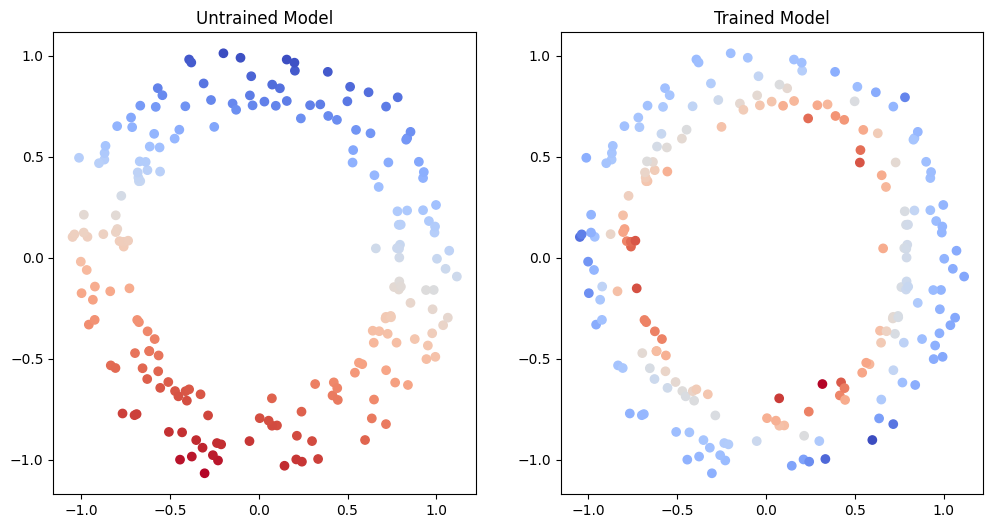

In [89]:
# Visualize the predictions

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Untrained Model")
plt.scatter(X_test[:, 0], X_test[:, 1], c=untrainded_preds.squeeze(-1).detach().cpu().numpy(), cmap="coolwarm")
plt.subplot(1, 2, 2)
plt.title("Trained Model")
plt.scatter(X_test[:, 0], X_test[:, 1], c=trained_preds.squeeze(-1).detach().cpu().numpy(), cmap="coolwarm")
plt.show()


In [90]:
i, ii = y_test[:-1], trained_preds[:-1].squeeze(-1).detach().cpu().numpy().round()

In [91]:
i == ii

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True, 

In [92]:
# COunt the number of false predictions

false_preds, true_preds = len(i) - sum(i == ii), sum(i == ii)

In [93]:
false_preds, true_preds

(tensor(6), tensor(193))

mdoel

In [95]:
model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 1.5849, -2.6473],
                      [ 3.2284, -0.4215],
                      [ 3.1400, -0.0118],
                      [-1.7203, -2.8315]])),
             ('0.bias', tensor([ 1.4315, -1.8358, -1.2369, -1.8253])),
             ('2.weight', tensor([[ 2.3424, -1.2062, -1.2043, -2.3826]])),
             ('2.bias', tensor([-2.8237]))])

## 5. Improving our model

- Increase the number of neurons in the hidden layer
- Increase the number of hidden layers
- Change the optimizer
- Change the learning rate
- Train for longer
- Change the activation functions
- Change the loss function

In [98]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, X):
        X = torch.tanh(self.layer_1(X))
        X = torch.tanh(self.layer_2(X))
        X = torch.sigmoid(self.layer_3(X))
        return X
    
model_2 = CircleModelV1().to(device)


In [101]:
# Create a loss function 
loss_function = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

In [108]:
# Write a training and evaluation loop

# Set the number of epochs
EPOCHS = 1000

# Put data to target device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# Buil training and evaluation loop
for epoch in range(EPOCHS):
    ### Training
    model_2.train()

    # 1. Forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_function(y_logits, 
                         y_train)
    
    acc = calculate_accuracy(y_true=y_train, 
                             y_pred=y_logits)
    
    # 3. Zero the gradients
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Update the model parameters
    optimizer.step()
    
    ### Testing
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_function(test_logits, 
                                  y_test)
        
        test_acc = calculate_accuracy(y_true=y_test, 
                                      y_pred=test_logits)
        
    # Print the metrics
    if epoch % 10 == 0:
        print(f"Epoch {epoch} -> Loss: {loss:.4f} - Acc: {acc:.2f}% - Test loss: {test_loss:.4f} - Test acc: {test_acc:.2f}%")

Epoch 0 -> Loss: 0.6972 - Acc: 51.00% - Test loss: 0.7039 - Test acc: 46.00%
Epoch 10 -> Loss: 0.6944 - Acc: 50.75% - Test loss: 0.6981 - Test acc: 46.00%
Epoch 20 -> Loss: 0.6932 - Acc: 45.38% - Test loss: 0.6946 - Test acc: 44.00%
Epoch 30 -> Loss: 0.6926 - Acc: 49.00% - Test loss: 0.6932 - Test acc: 50.50%
Epoch 40 -> Loss: 0.6921 - Acc: 53.00% - Test loss: 0.6929 - Test acc: 49.00%
Epoch 50 -> Loss: 0.6916 - Acc: 52.25% - Test loss: 0.6929 - Test acc: 49.50%
Epoch 60 -> Loss: 0.6910 - Acc: 53.12% - Test loss: 0.6925 - Test acc: 50.00%
Epoch 70 -> Loss: 0.6903 - Acc: 53.50% - Test loss: 0.6917 - Test acc: 51.50%
Epoch 80 -> Loss: 0.6896 - Acc: 55.75% - Test loss: 0.6907 - Test acc: 51.50%
Epoch 90 -> Loss: 0.6887 - Acc: 57.38% - Test loss: 0.6896 - Test acc: 53.00%
Epoch 100 -> Loss: 0.6877 - Acc: 58.75% - Test loss: 0.6885 - Test acc: 55.00%
Epoch 110 -> Loss: 0.6865 - Acc: 62.12% - Test loss: 0.6870 - Test acc: 60.00%
Epoch 120 -> Loss: 0.6851 - Acc: 67.88% - Test loss: 0.6852 - T

In [109]:
# Make predictions with the trained model

model_2.eval()
trained_preds = model_2(X_test.to(device))

In [113]:
trained_preds.squeeze(-1).detach().cpu().numpy().round()

array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)

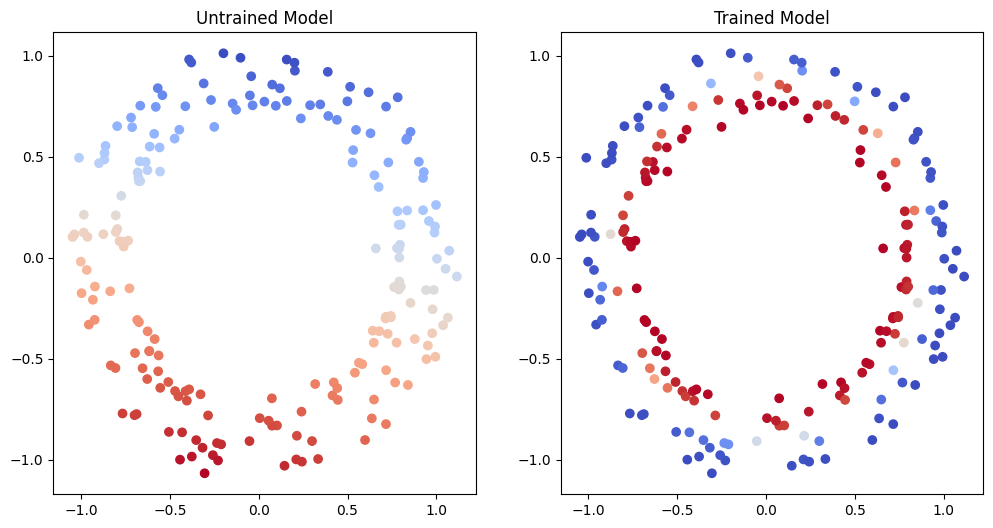

In [114]:
# Visualize the predictions

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Untrained Model")
plt.scatter(X_test[:, 0], X_test[:, 1], c=untrainded_preds.squeeze(-1).detach().cpu().numpy(), cmap="coolwarm")
plt.subplot(1, 2, 2)
plt.title("Trained Model")
plt.scatter(X_test[:, 0], X_test[:, 1], c=trained_preds.squeeze(-1).detach().cpu().numpy(), cmap="coolwarm")
plt.show()


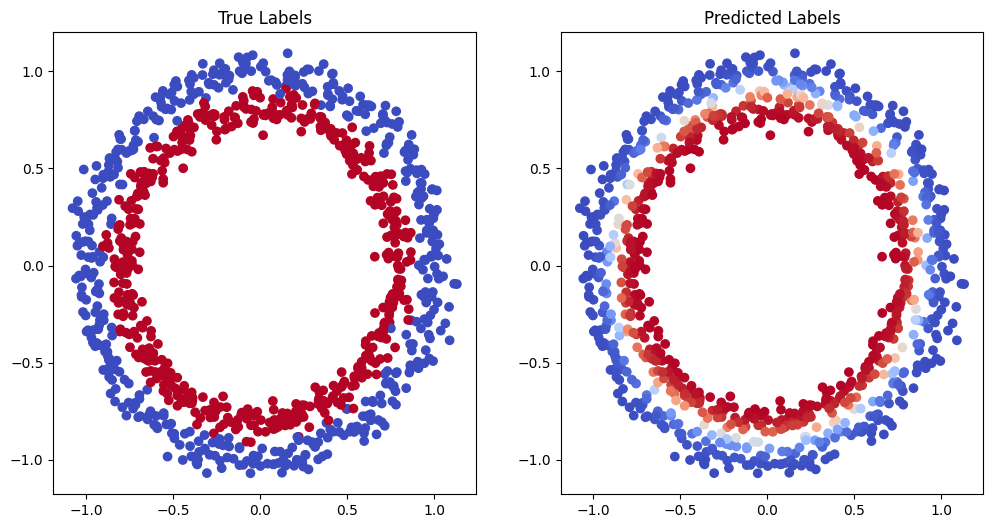

In [115]:
# Make a prediction on the full dataset
full_preds = model_2(X.to(device))

# Visualize the full dataset
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("True Labels")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm")
plt.subplot(1, 2, 2)
plt.title("Predicted Labels")
plt.scatter(X[:, 0], X[:, 1], c=full_preds.squeeze(-1).detach().cpu().numpy(), cmap="coolwarm")
plt.show()


In [116]:
# Compare the true labels with the predicted labels
full_preds_binary = torch.round(torch.sigmoid(full_preds)).squeeze(-1).detach().cpu().numpy()

# View the number of true and false predictions
false_preds, true_preds = len(y) - sum(y == full_preds_binary), sum(y == full_preds_binary)

false_preds, true_preds

(tensor(500), tensor(500))

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [118]:
# Create some data

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(1)
y_regression = weight * X_regression + bias

# Check the data
print(f"X_regression: {X_regression[:5]}")

X_regression: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]])


In [119]:
# Create train and test sets
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_regression, y_regression, test_size=0.2)

In [120]:
len(X_reg_train), len(X_reg_test), len(y_reg_train), len(y_reg_test)

(80, 20, 80, 20)

In [127]:
# import helper functions

import requests
import os

def download_file(url, save_as):
    response = requests.get(url)
    with open(save_as, "wb") as file:
        file.write(response.content)

# Import helper functions
if "helper_functions.py" not in os.listdir():
    download_file(url="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py",
                  save_as="helper_functions.py")

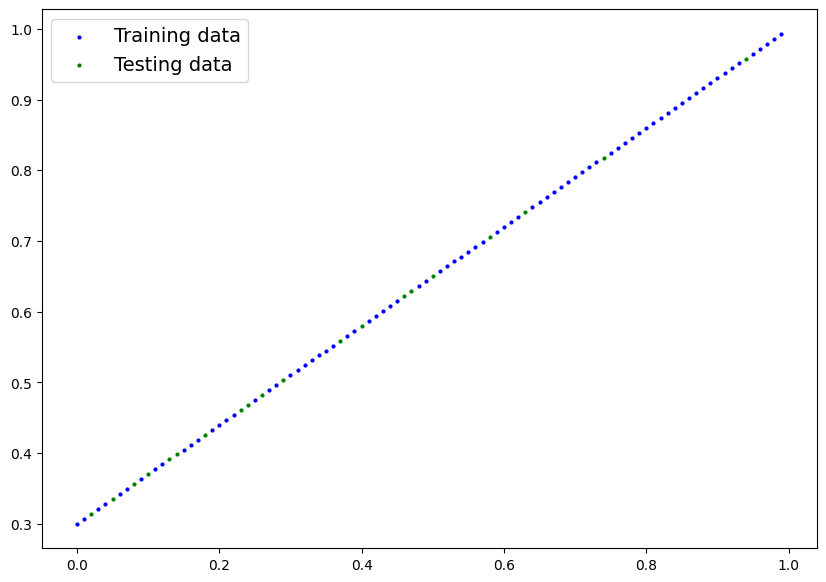

In [134]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot the regression data
plot_predictions(train_data=X_reg_train, 
                 train_labels=y_reg_train, 
                 test_data=X_reg_test, 
                 test_labels=y_reg_test)

### 5.1 Adjusting `model_2` to fit a straight line

In [143]:
# Same architecture as model_2 (but using nn.Sequential())


model_3 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    # nn.Tanh(),
    nn.Linear(in_features=10, out_features=10),
    # nn.ReLU(),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_3

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [144]:
# Loss function and optimizer

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(params=model_3.parameters(), 
                             lr=0.001)

In [145]:
# Train the model

# Set the number of epochs
EPOCHS = 1000

# Put data to target device
X_reg_train, y_reg_train, X_reg_test, y_reg_test = X_reg_train.to(device), y_reg_train.to(device), X_reg_test.to(device), y_reg_test.to(device)

# Buil training and evaluation loop

for epoch in range(EPOCHS):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_pred = model_3(X_reg_train)

    # 2. Calculate loss/accuracy
    loss = loss_function(y_pred, 
                         y_reg_train)
    
    # 3. Zero the gradients
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Update the model parameters
    optimizer.step()
    
    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_pred = model_3(X_reg_test)

        test_loss = loss_function(test_pred, 
                                  y_reg_test)
        
    # Print the metrics
    if epoch % 10 == 0:
        print(f"Epoch {epoch} -> Loss: {loss:.4f} - Test loss: {test_loss:.4f}")

Epoch 0 -> Loss: 0.8469 - Test loss: 0.5649
Epoch 10 -> Loss: 0.5768 - Test loss: 0.3632
Epoch 20 -> Loss: 0.3598 - Test loss: 0.2078
Epoch 30 -> Loss: 0.1982 - Test loss: 0.0998
Epoch 40 -> Loss: 0.0925 - Test loss: 0.0378
Epoch 50 -> Loss: 0.0372 - Test loss: 0.0145
Epoch 60 -> Loss: 0.0176 - Test loss: 0.0146
Epoch 70 -> Loss: 0.0146 - Test loss: 0.0206
Epoch 80 -> Loss: 0.0146 - Test loss: 0.0226
Epoch 90 -> Loss: 0.0139 - Test loss: 0.0208
Epoch 100 -> Loss: 0.0130 - Test loss: 0.0181
Epoch 110 -> Loss: 0.0123 - Test loss: 0.0161
Epoch 120 -> Loss: 0.0117 - Test loss: 0.0150
Epoch 130 -> Loss: 0.0111 - Test loss: 0.0142
Epoch 140 -> Loss: 0.0105 - Test loss: 0.0137
Epoch 150 -> Loss: 0.0100 - Test loss: 0.0131
Epoch 160 -> Loss: 0.0094 - Test loss: 0.0124
Epoch 170 -> Loss: 0.0089 - Test loss: 0.0117
Epoch 180 -> Loss: 0.0083 - Test loss: 0.0110
Epoch 190 -> Loss: 0.0078 - Test loss: 0.0103
Epoch 200 -> Loss: 0.0073 - Test loss: 0.0096
Epoch 210 -> Loss: 0.0068 - Test loss: 0.0090

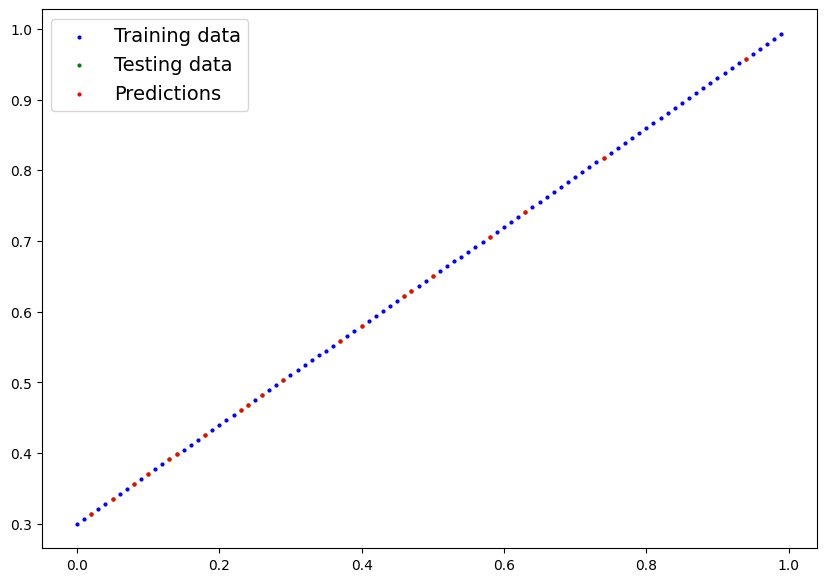

In [150]:
# Turn on evaluation mode
model_3.eval()

# Make predictions
with torch.inference_mode():
    y_reg_preds = model_3(X_reg_test)

# Plot the predictions
plot_predictions(train_data=X_reg_train, 
                 train_labels=y_reg_train, 
                 test_data=X_reg_test, 
                 test_labels=y_reg_test, 
                 predictions=y_reg_preds)

In [152]:
model_3.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6841],
                      [ 0.0522],
                      [-0.9073],
                      [ 0.4184],
                      [-0.1698],
                      [ 0.7406],
                      [ 0.1106],
                      [-0.0854],
                      [-0.8430],
                      [-0.0656]])),
             ('0.bias',
              tensor([ 0.7663, -0.2156, -0.4710, -0.7030,  0.0796,  0.8802,  0.3837,  0.4681,
                      -0.0991, -0.4074])),
             ('1.weight',
              tensor([[-0.1152, -0.0905, -0.0143, -0.1304, -0.2192,  0.0357,  0.1064, -0.1505,
                       -0.3188, -0.2044],
                      [ 0.3260,  0.1997, -0.2269, -0.0491, -0.1037, -0.0252,  0.1238, -0.0621,
                        0.0445, -0.0706],
                      [-0.2151, -0.0305,  0.1522,  0.2703, -0.0973, -0.2698, -0.2662,  0.1885,
                       -0.0260,  0.1024],
                      [-0.0984, -0.0596, -0

## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

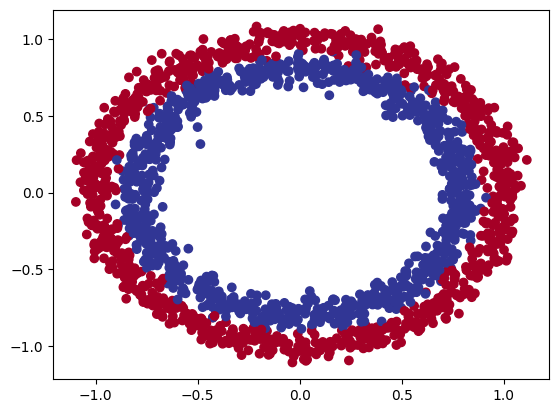

In [167]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 2000

X, y = make_circles(n_samples, 
                    noise=0.05)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [174]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 6.2 Building a model with non-linear activation functions

In [195]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=100)
        self.layer_2 = nn.Linear(in_features=100, out_features=100)
        self.layer_3 = nn.Linear(in_features=100, out_features=1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, X):
        X = self.tanh(self.layer_1(X))
        X = self.relu(self.layer_2(X))
        X = torch.sigmoid(self.layer_3(X))
        return X
    
model_4 = CircleModelV2().to(device)

In [196]:
model_4

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=1, bias=True)
  (tanh): Tanh()
  (relu): ReLU()
)

In [201]:
# Setup the loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(), 
                             lr=0.001)

### 6.3 Train the model

In [202]:
# Put data to target device
X_train, y_train = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device)

# Set the number of epochs
EPOCHS = 1000

# Buil training and evaluation loop

for epoch in range(EPOCHS):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_function(y_logits, 
                         y_train)
    
    acc = calculate_accuracy(y_true=y_train, 
                             y_pred=y_pred)
    
    # 3. Zero the gradients
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Update the model parameters
    optimizer.step()
    
    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_function(test_logits, 
                                  y_test)
        
        test_acc = calculate_accuracy(y_true=y_test, 
                                      y_pred=test_logits)
        
    # Print the metrics
    if epoch % 10 == 0:
        print(f"Epoch {epoch} -> Loss: {loss:.4f} - Acc: {acc:.2f}% - Test loss: {test_loss:.4f} - Test acc: {test_acc:.2f}%")

/tmp/ipykernel_2649683/3108145586.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_2649683/3108145586.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device)


Epoch 0 -> Loss: 0.5081 - Acc: 94.31% - Test loss: 0.5228 - Test acc: 96.25%
Epoch 10 -> Loss: 0.5080 - Acc: 93.62% - Test loss: 0.5216 - Test acc: 97.00%
Epoch 20 -> Loss: 0.5080 - Acc: 93.81% - Test loss: 0.5214 - Test acc: 97.25%
Epoch 30 -> Loss: 0.5080 - Acc: 93.94% - Test loss: 0.5214 - Test acc: 97.25%
Epoch 40 -> Loss: 0.5079 - Acc: 94.06% - Test loss: 0.5214 - Test acc: 97.25%
Epoch 50 -> Loss: 0.5079 - Acc: 93.88% - Test loss: 0.5215 - Test acc: 97.25%
Epoch 60 -> Loss: 0.5079 - Acc: 93.88% - Test loss: 0.5214 - Test acc: 97.25%
Epoch 70 -> Loss: 0.5079 - Acc: 93.94% - Test loss: 0.5214 - Test acc: 97.25%
Epoch 80 -> Loss: 0.5079 - Acc: 94.00% - Test loss: 0.5214 - Test acc: 97.25%
Epoch 90 -> Loss: 0.5079 - Acc: 93.94% - Test loss: 0.5213 - Test acc: 97.25%
Epoch 100 -> Loss: 0.5079 - Acc: 94.06% - Test loss: 0.5213 - Test acc: 97.25%
Epoch 110 -> Loss: 0.5079 - Acc: 94.06% - Test loss: 0.5212 - Test acc: 97.25%
Epoch 120 -> Loss: 0.5079 - Acc: 94.06% - Test loss: 0.5212 - T

### 6.4 Evaluating a model trained with non-linear activation functions

In [203]:
# Make predictions with the trained model

model_4.eval()
with torch.inference_mode():
    trained_preds = model_4(X_test)

(trained_preds.squeeze(-1).detach().cpu().numpy().round() == y_test).sum() - len(y_test)

tensor(-12)

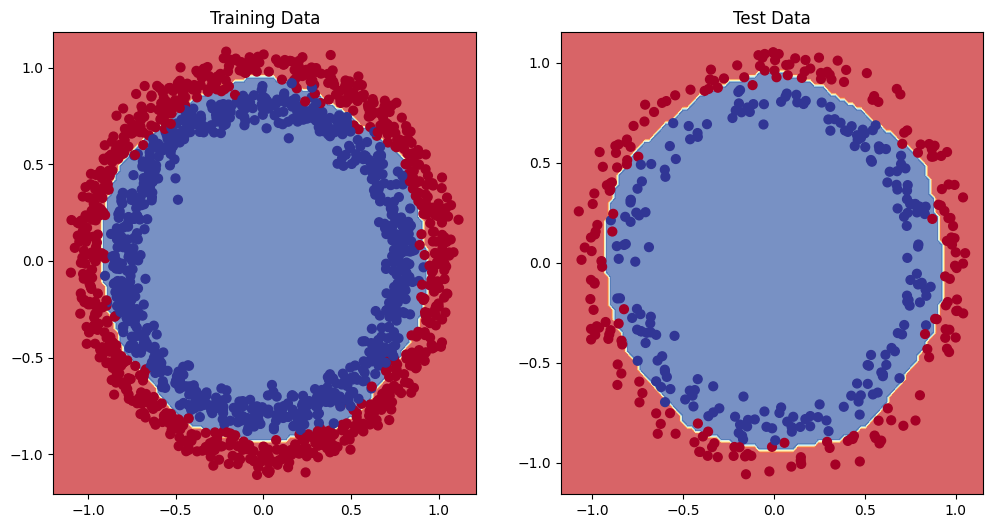

In [204]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training Data")
plot_decision_boundary(model=model_4, 
                       X=X_train, 
                       y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test Data")
plot_decision_boundary(model=model_4, 
                       X=X_test, 
                       y=y_test)

In [205]:
## 7. Replication non-linear activation function

In [225]:
# Create a tensor
X = torch.arange(-10, 10, 1).float()

In [226]:
X

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [227]:
X.shape

torch.Size([20])

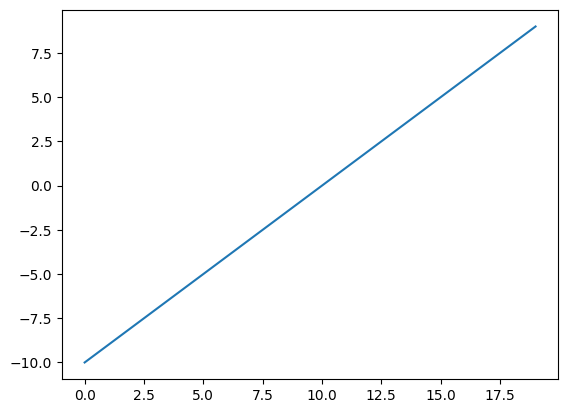

In [230]:
plt.plot(X.numpy())

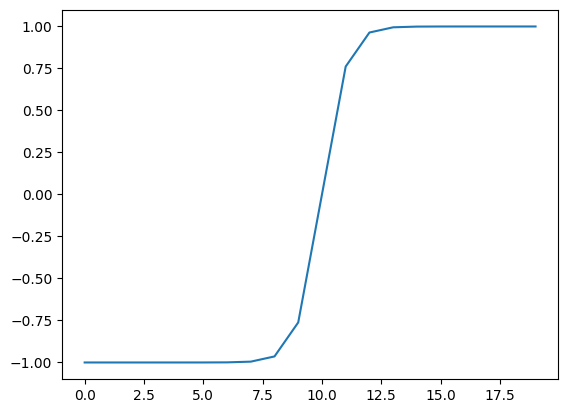

In [231]:
plt.plot(torch.tanh(X).numpy())

In [240]:
def tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

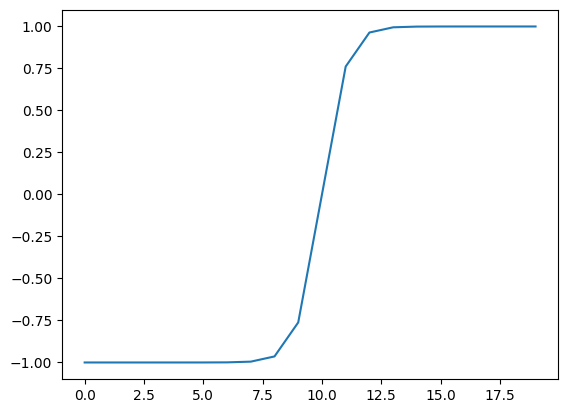

In [242]:
plt.plot(tanh(X).numpy())

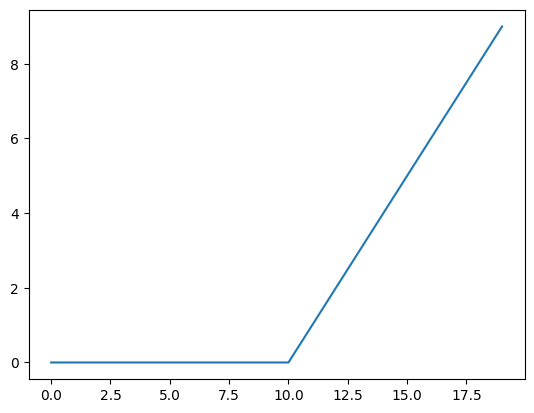

In [232]:
plt.plot(torch.relu(X).numpy())

In [233]:
def relu(x):
    return torch.max(torch.tensor(0), x)

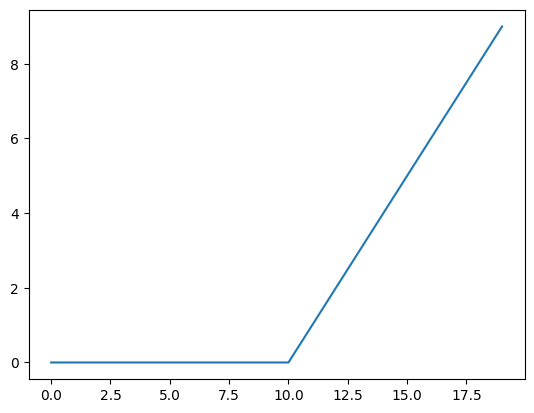

In [237]:
plt.plot(relu(X).numpy())

## 8. Putting it all together to build a multi-class classification model

### 8.1 Creating a toy multi-class classification dataset

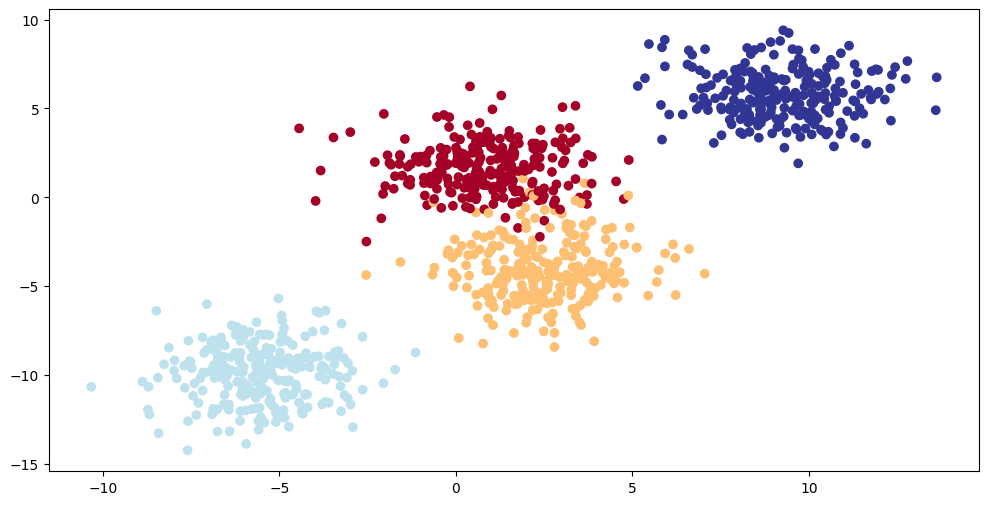

In [293]:
# Make some imports
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for the data creation
NUM_CLASSES = 4
NUM_FEATURES = 2

# 1. Creating multiclass data
X_bob, y_bob = make_blobs(n_samples=1000,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            n_features=NUM_FEATURES)

# 2. Turn data into tensors
X_bob = torch.tensor(X_bob, dtype=torch.float32)
y_bob = torch.tensor(y_bob, dtype=torch.float32)

# 3. Split the data
X_bob_train, X_bob_test, y_bob_train, y_bob_test = train_test_split(X_bob, y_bob, test_size=0.2)

# 4. Plot the data
plt.figure(figsize=(12, 6))
plt.scatter(X_bob[:, 0], X_bob[:, 1], c=y_bob, cmap=plt.cm.RdYlBu)

### 8.2 Create a multiclass classification model

In [296]:
# Creating device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [320]:
# Build a multi-class classification model

class BobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification model.

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features to the model (number of classes)
            hidden_units (int, optional): Number of hidden units between layers. Defaults to 8.

        Returns:

        Example:
            model = BobModel(input_features=2, output_features=4, hidden_units=8)
        """ 

        super(BobModel, self).__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, X):
        """Forward pass of the model.

        Args:
            X (torch.Tensor): Input data to the model

        Returns:
            torch.Tensor: Output of the model
        """
        return self.linear_layer_stack(X)
    
# Instantiate the model
model_bob = BobModel(input_features=NUM_FEATURES, 
                     output_features=NUM_CLASSES,
                     hidden_units=8).to(device)

model_bob

BobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [321]:
model_bob.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.1079,  0.1963],
                      [-0.2122, -0.0705],
                      [-0.0122,  0.2182],
                      [ 0.0059,  0.0130],
                      [ 0.6319,  0.3701],
                      [-0.6016,  0.6470],
                      [ 0.3818, -0.2505],
                      [ 0.2867, -0.0816]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.2849, -0.3798,  0.1103, -0.2732, -0.0464,  0.2742,  0.1186,  0.2009])),
             ('linear_layer_stack.2.weight',
              tensor([[ 0.1321,  0.1909,  0.3354,  0.2246, -0.1730, -0.1880,  0.2437, -0.2290],
                      [-0.1311, -0.2185,  0.1042, -0.0974,  0.1493, -0.2023, -0.1834, -0.0815],
                      [-0.0158, -0.3253, -0.0419,  0.1642, -0.2639,  0.1738,  0.1929,  0.0094],
                      [ 0.3290,  0.1222,  0.3533,  0.1184,  0.2078, -0.3376,  0.0733, -0.2595],
                      [ 0.2569,  0.2941,  0.105

### 8.3 Setup the loss function and optimizer for multi-class classification

In [322]:
# Setup the loss function and optimizer
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_bob.parameters(), 
                             lr=0.001)

### 8.4 Getting prediction probabilities for multi-class classification

In [323]:
# y_logits = model_bob(X_bob_train.to(device))

In [332]:
model_bob.eval()
with torch.inference_mode():
    y_logits = model_bob(X_bob_train.to(device))

y_logits

tensor([[ 0.3618, -0.6777,  0.1175,  0.0736],
        [ 0.3242, -0.4438,  0.1802, -0.0667],
        [ 1.2694, -2.1327, -0.4557, -0.0300],
        ...,
        [ 0.1089, -0.2929,  0.1699,  0.1409],
        [ 0.2309, -0.3607,  0.1301, -0.0563],
        [ 1.1181, -1.9551, -0.3549, -0.0974]])

In [334]:
y_pred_probs = torch.softmax(y_logits, dim=1)

In [335]:
y_pred_probs

tensor([[0.3464, 0.1225, 0.2714, 0.2597],
        [0.3326, 0.1543, 0.2880, 0.2250],
        [0.6738, 0.0224, 0.1200, 0.1837],
        ...,
        [0.2656, 0.1777, 0.2823, 0.2743],
        [0.3117, 0.1725, 0.2818, 0.2339],
        [0.6361, 0.0294, 0.1458, 0.1886]])

In [336]:
y_pred = torch.argmax(y_pred_probs, dim=1)

In [337]:
y_pred

tensor([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0,
        2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0,
        0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
        0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2,

### 8.5 Creating a training loop and evaluation loop for multi-class classification

In [340]:
# Fit the multi-class model to the data

# Set the number of epochs
EPOCHS = 1000

# Put data to target device
X_bob_train, y_bob_train = X_bob_train.to(device), y_bob_train.to(device)
X_bob_test, y_bob_test = X_bob_test.to(device), y_bob_test.to(device)

# Buil training and evaluation loop

for epoch in range(EPOCHS):
    ### Training
    model_bob.train()

    # 1. Forward pass
    y_logits = model_bob(X_bob_train)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_probs, dim=1)

    # 2. Calculate loss/accuracy
    loss = loss_function(y_logits, 
                         y_bob_train.long())
    
    acc = calculate_accuracy(y_true=y_bob_train.long(),
                                y_pred=y_pred)
    
    # 3. Zero the gradients
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Update the model parameters
    optimizer.step()

    ### Testing
    model_bob.eval()
    with torch.inference_mode():
        test_logits = model_bob(X_bob_test)
        test_pred_probs = torch.softmax(test_logits, dim=1)
        test_pred = torch.argmax(test_pred_probs, dim=1)

        test_loss = loss_function(test_logits, 
                                  y_bob_test.long())
        
        test_acc = calculate_accuracy(y_true=y_bob_test.long(),
                                      y_pred=test_pred)
        
    # Print the metrics
    if epoch % 10 == 0:
        print(f"Epoch {epoch} -> Loss: {loss:.4f} - Acc: {acc:.2f}% - Test loss: {test_loss:.4f} - Test acc: {test_acc:.2f}%")

Epoch 0 -> Loss: 0.8479 - Acc: 82.88% - Test loss: 0.8560 - Test acc: 83.50%
Epoch 10 -> Loss: 0.8014 - Acc: 84.38% - Test loss: 0.8078 - Test acc: 84.00%
Epoch 20 -> Loss: 0.7551 - Acc: 85.88% - Test loss: 0.7598 - Test acc: 86.50%
Epoch 30 -> Loss: 0.7092 - Acc: 87.12% - Test loss: 0.7122 - Test acc: 89.50%
Epoch 40 -> Loss: 0.6640 - Acc: 88.50% - Test loss: 0.6652 - Test acc: 90.50%
Epoch 50 -> Loss: 0.6197 - Acc: 89.38% - Test loss: 0.6191 - Test acc: 91.00%
Epoch 60 -> Loss: 0.5767 - Acc: 90.75% - Test loss: 0.5744 - Test acc: 91.50%
Epoch 70 -> Loss: 0.5353 - Acc: 91.75% - Test loss: 0.5315 - Test acc: 93.00%
Epoch 80 -> Loss: 0.4963 - Acc: 92.38% - Test loss: 0.4907 - Test acc: 94.00%
Epoch 90 -> Loss: 0.4598 - Acc: 92.62% - Test loss: 0.4529 - Test acc: 94.00%
Epoch 100 -> Loss: 0.4260 - Acc: 92.62% - Test loss: 0.4177 - Test acc: 94.50%
Epoch 110 -> Loss: 0.3950 - Acc: 93.12% - Test loss: 0.3859 - Test acc: 95.00%
Epoch 120 -> Loss: 0.3667 - Acc: 93.62% - Test loss: 0.3567 - T

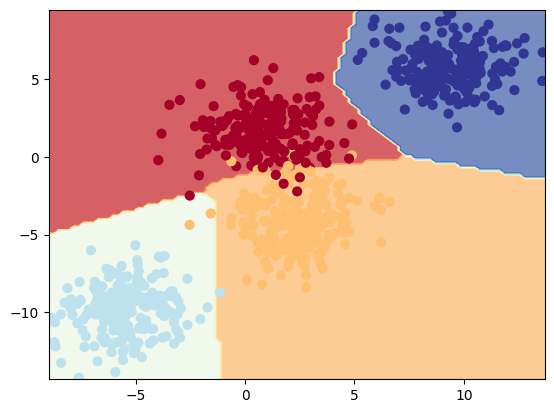

In [341]:
plot_decision_boundary(model=model_bob,
                          X=X_bob_train,
                          y=y_bob_train)

In [342]:
### 8.6 Making predictions with the trained model

In [349]:
# Make predictions with the trained model
model_bob.eval()
with torch.inference_mode():
    y_logits = model_bob(X_bob_test)

y_logits[:5]

tensor([[  5.6152,  -2.3209,  -4.2458,  -5.8667],
        [ -2.1266,  -3.3510,   4.9479,  -5.5965],
        [ -0.2566, -12.4492,  -7.9387,   4.9880],
        [ -1.0425,  -7.9095,  -6.4377,   3.7679],
        [ -2.7525,   4.2801,  -2.9890,  -5.3126]])

In [350]:
# Go from logits to probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[9.9958e-01, 3.5743e-04, 5.2149e-05, 1.0311e-05],
        [8.4542e-04, 2.4851e-04, 9.9888e-01, 2.6310e-05],
        [5.2484e-03, 2.6597e-08, 2.4194e-06, 9.9475e-01],
        [8.0783e-03, 8.4143e-06, 3.6664e-05, 9.9188e-01],
        [8.8121e-04, 9.9836e-01, 6.9560e-04, 6.8117e-05]])

In [352]:
y_test_preds = torch.argmax(y_pred_probs, dim=1)
y_test_preds[:5], y_bob_test[:5]

(tensor([0, 2, 3, 3, 1]), tensor([0., 2., 3., 3., 1.]))

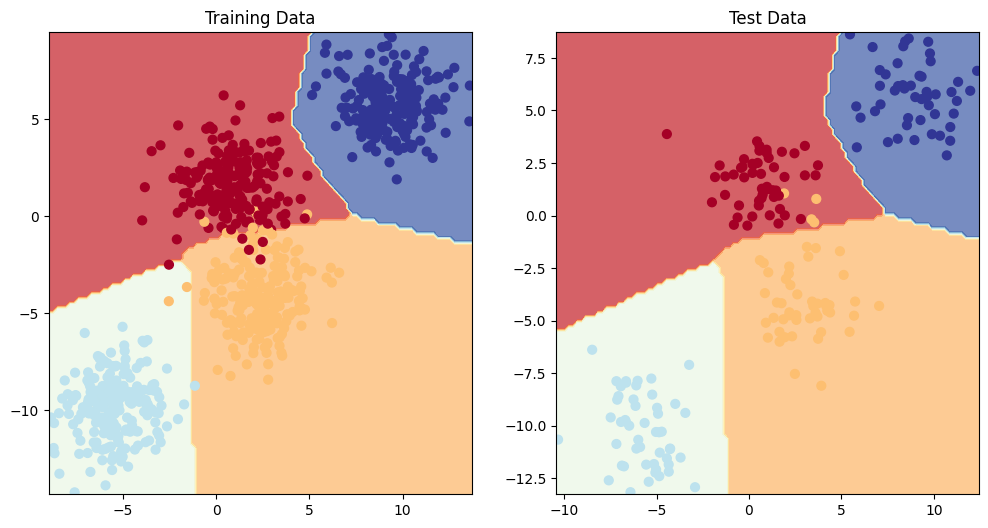

In [353]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training Data")
plot_decision_boundary(model=model_bob, 
                       X=X_bob_train, 
                       y=y_bob_train)
plt.subplot(1, 2, 2)
plt.title("Test Data")
plot_decision_boundary(model=model_bob, 
                       X=X_bob_test, 
                       y=y_bob_test)